# Demo for generating substrates and running a single simulation
This notebook is intended as a demo that reproduces a single simulation with generic parameters for the substrate geometry and the sequence applied. Readers are free to alter the parameters and use this as a base example for their own explorations. For a more general introduction to MCMRSimulator, see [its dedicated tutorial](https://open.win.ox.ac.uk/pages/ndcn0236/mcmrsimulator.jl/v0.11/). Note this demo uses the latest stable version of MCMRSimulator as of 2025-1, v0.11.0 and in our paper we used v0.9.0.

## Set up environment and import packages

In [1]:
using Pkg
# Activate the specific environment with the correct packages and version 
Pkg.activate("julia-envs/modern_mcmr")
Pkg.instantiate()
# Import packages
using MCMRSimulator
using MRIBuilder
using CairoMakie
using DelimitedFiles
using Printf
using JLD2

  Activating project at `~/Library/CloudStorage/OneDrive-Nexus365/projects/Papers/2024 MRM/gitrepo/MT-and-permeability-effect-on-two-compartment-dMRI-WM-model/julia-envs/modern_mcmr`


In [2]:
# Create output directory if it does not exist
mkpath("example_output")

"example_output"

## Create substrates
To generate parallel cylinder substrates for our simulation, we will call `random_positions_radii()` for generating positions and radius values for a given volume density value and radius distribution (Gamma distribution characterised by mean and variance) and call `Cylinders()` to create the substrate object in simulation.

In [3]:

# Set various parameters for the substrate
T2 = 100                          # effective T2 caused by MT (ms)
rho = 0.65                        # cylinder volume density
r = 1                             # cylinder radius (μm)
rep = r*20                        # (half of) the distance over which the substrate repeats itself spatially

# Set MT (surface relaxivity) and permeability
T2_bound = 1e-3                   # Bound pool T2 to model surface relaxivity (ms)
t_dwell = 30                      # Dwell time of isochromats in the bound pool, controls the strength of surface relaxivity
svratio = 2/r                     # Calculate the surface to volume ratio that is used to calculate the surface density later
surf_dens = 1/svratio*t_dwell/T2  # Surface density of isochromats that achieves the given T2, it's the ratio of isochromat density on the substrate (cylinder) and isochromat density in the volume of interest
perm = 0.005                      # permeability, probability for an isochromat to pass through the cylinder wall when they encounter

# Create a substrate with parallel cylinders of fixed diameters 
res = MCMRSimulator.random_positions_radii([rep, rep], rho, 2, mean=r, variance=0, max_iter=1000, repulsion_strength=3e-3)                                      # generate cylinder center positions based on slightly larger radius to avoid overlapping
fixed_d_cyl = Cylinders(position=res[1], radius=r, dwell_time=t_dwell, density=surf_dens, permeability=perm, repeats=[rep, rep], R2_surface=1/T2_bound)         # create the cylinders object with refined positions
MCMRSimulator.write_geometry("example_output/cylinders_MT_"* string(T2) *"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.json", fixed_d_cyl)  # it's possible to save the object as a .json file to be read by MCMRSimulator later 


Similarly, we can also create substrates containing parallel cylinders with Gamma-distributed diameters, note this may take a bit longer than the fixed diameter case.

In [4]:

# Set various parameters for the substrate
T2 = 100                          # effective T2 caused by MT (ms)
rho = 0.65                        # cylinder volume density
r = 1                             # mean cylinder radius (μm)
r_var = 1                         # variance of cylinder radius (μm^2)
rep = r*20                        # (half of) the distance over which the substrate repeats itself spatially

# Set MT (surface relaxivity) and permeability
T2_bound = 1e-3                   # Bound pool T2 to model surface relaxivity (ms)
t_dwell = 30                      # Dwell time of isochromats in the bound pool, controls the strength of surface relaxivity
svratio = 2/r                     # Calculate the surface to volume ratio that is used to calculate the surface density later
surf_dens = 1/svratio*t_dwell/T2  # Surface density of isochromats that achieves the given T2, it's the ratio of isochromat density on the substrate (cylinder) and isochromat density in the volume of interest
perm = 0.005                      # permeability, probability for an isochromat to pass through the cylinder wall when they encounter

# Create a substrate with parallel cylinders of distributed diameters 
res = MCMRSimulator.random_positions_radii([rep, rep], rho, 2, mean=r, variance=r_var, max_iter=1000, repulsion_strength=1e-2)                                       # generate cylinder center positions and radii following the mean and variance
distr_d_cyl = Cylinders(position=res[1], radius=res[2], dwell_time=t_dwell, density=surf_dens, permeability=perm, repeats=[rep, rep], R2_surface=1/T2_bound)         # create the cylinders object with refined positions
MCMRSimulator.write_geometry("example_output/cylinders_MT_"* string(T2) *"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_rvar_"*@sprintf("%.2f", r_var)*"_density_0.65.json", distr_d_cyl)  # it's possible to save the object as a .json file to be read by MCMRSimulator later 


It is possible to plot the geometry to visually check it

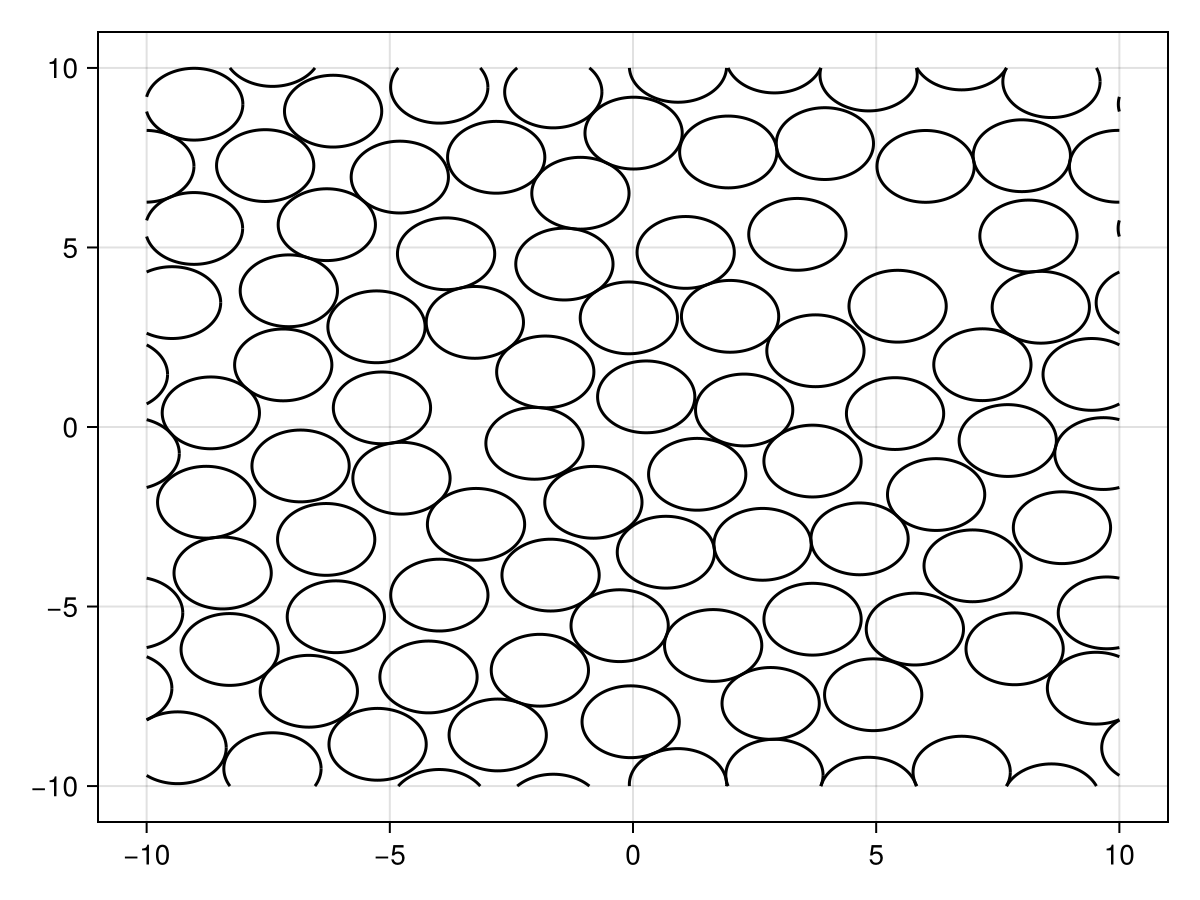

In [5]:
f = plot(PlotPlane(size=20), fixed_d_cyl)

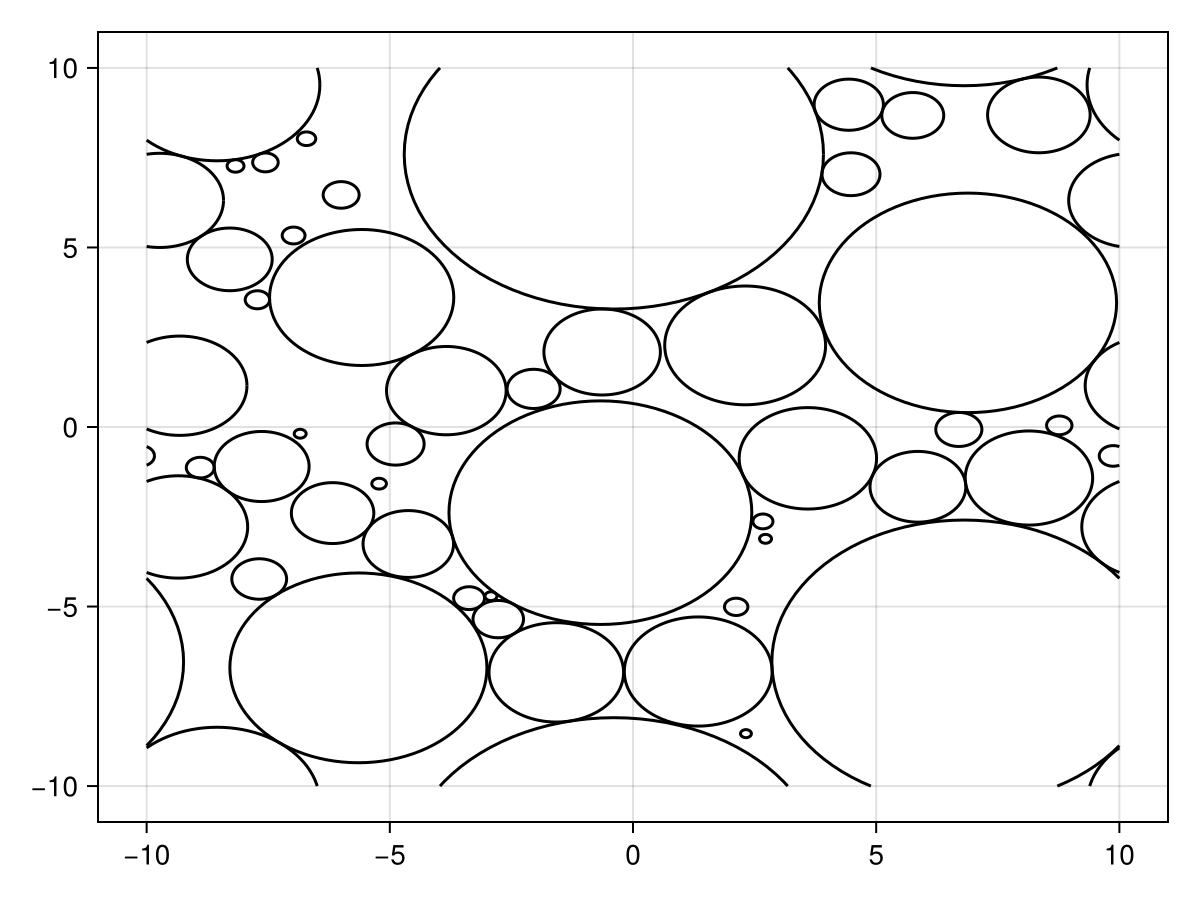

In [6]:
f = plot(PlotPlane(size=20), distr_d_cyl)

## Create diffusion-weighted spin-echo sequence
This step involves using the `MRIBuilder` package, a new package compatable with MCMRSimulator, designed for building generic sequences using optimisation tools. Here we will just use the `DiffusionSpinEcho()` function to create a DWSE sequence. For more generic use, see [its documentation](https://open.win.ox.ac.uk/pages/ndcn0236/mribuilder.jl/dev/) for more details.

This step just uses built-in function `dwi()` of MCMRSimulator. It allows the user to set many parameters of the DWSE sequence. In our case, gradient_duration, gradient_strength, diffusion_time, TE, and TR were set. For a more detailed explanation and general use of the function, check the [MCMRSimulator tutorial](https://open.win.ox.ac.uk/pages/ndcn0236/mcmrsimulator.jl/v0.9/sequence/#sequence). Note in the later versions of MCMRSimulator, a new package `MRIBuilder` was created for building generic sequences using optimisation tools. See [its documentation](https://open.win.ox.ac.uk/pages/ndcn0236/mribuilder.jl/dev/) for more details.

In [7]:
# Set sequence parameters
axcaliber7T = Scanner(B0=7., gradient=1460, slew_rate=1e10, units=:Tesla) # Define the scanner hardware limits, gradient means maximum gradient strength (mT/m), set a very high slew rate so the ramp time is almost zero.
TR=3000                 # ms
TE=166                  # ms
delta=2.5               # gradient duration (ms)
g=1200                  # gradient strength (mT/m)
gamma=0.00004257638476  # gyromagnetic ratio for proton (kHz/mT ̇1e-6), needed as dwi() takes gradient strength with kHz/μm unit
Delta=20                # diffusion time (ms)

# Create the sequence using DiffusionSpinEcho()
seq = DiffusionSpinEcho(echo_time=TE, diffusion_time=Delta, gradient=(gradient_strength=[g*gamma, 0., 0.], duration=delta), scanner=axcaliber7T)
write_sequence("example_output/seq_difftime_"*@sprintf("%.1f",Delta)*"_gdur_"*@sprintf("%.1f",delta)*".jld2", seq, format=:serialize) # the sequence object can be saved for future uses 



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



It is also possible to plot the sequence diagram, note the diffusion-encoding gradients are not symmetric around the refocusing pulse because the MRIBuilder is set to maximise the time between the end of 2nd gradient and the readout to minimise the eddy current effects.

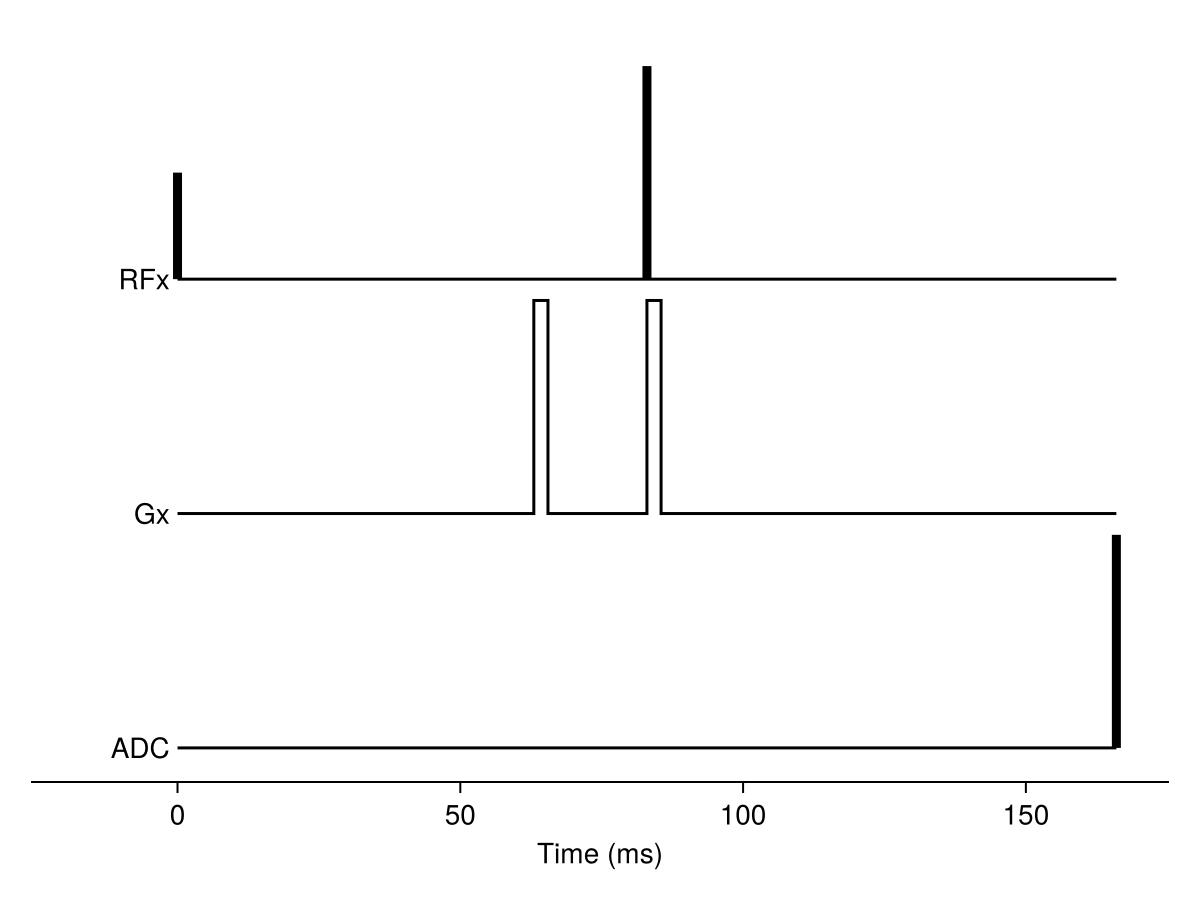

In [8]:
f = plot_sequence(seq)
f

## Run the simulation and generate signal
Now we have both the substrate and sequence, we can run the simulation by calling the `Simulation()` constructor and get a readout of the final signal level using the `readout()` function. For more details about `readout()`, check the [MCMRSimulator tutorial](https://open.win.ox.ac.uk/pages/ndcn0236/mcmrsimulator.jl/v0.11/tutorial_julia/#Simple-signal-readouts).

In [9]:
# Construct the simulation object with Simulation() and our sequence (seq) and substrate (fixed_d_cyl) objects as inputs, diffusivity value can be changed depending on the substrate
d = 2.3     # intrinsic diffusivity (μm^2/ms)
sim = Simulation(seq, diffusivity=d, geometry=fixed_d_cyl) # fixed_d_cyl can be replaced by distr_d_cyl

# Use readout() to obtain the signal level given a certain number of isochromats, the bounding box defines the region of interest, an appropriate size is set to be relevant to the repetition scale of the substrate (rep) without including too many cylinders and significantly slowing down the simulation. The subset argument allows us to obtain signals from different parts of the substrate geometry (inside cylinders, outside cylinders, total signal).
sz = rep*2                                    # Scale of bounding box (i.e. volume of interest), here the volume is cubic so only one number is needed to characterise it.
bbox = BoundingBox([-sz,-sz,-sz],[sz,sz,sz])  # Create the bounding box (cuboid) by setting its lower and upper vertices along the diagonal.
n_isochromat = 10000                           # number of isochromats, larger number can lead to lower noise floor level but will slow down the simulation.
sig = readout(n_isochromat, sim, bounding_box=bbox, subset=[Subset(inside=true), Subset(inside=false), Subset()])  # Unless specified otherwise, readout() gives the signal at the time of TE with zero readout duration.

# The output signal can be written to a csv file and analysed later in python or other language/software, note transverse() is applied to the simulated signal as we can only read the transverse signal in reality.
println("Intraaxonal diffusion-weighted signal: ", transverse.(sig)[1])
println("Extraaxonal diffusion-weighted signal: ", transverse.(sig)[2])
println("Total diffusion-weighted signal: ", transverse.(sig)[3])
println("Total initial (b=0) signal: ", n_isochromat)
writedlm("example_output/signal_MT_"*@sprintf("%d",T2)*"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.csv", transverse.(sig), ',')

┌ Info: # Timestep determination
│ Maximum timestep set by tortuosity constraint based on size of geometry to 0.013043478260869566 ms.
│ Size scale of smallest object in the simulation was automatically determined to be 1.0 um.
│ If this value is too small, you can set the size scale explicitly by passing on `size_scale=<new_value>` to the `Simulator` constructor.
└ The actual timestep will be reduced based on the MR sequence(s).


Intraaxonal diffusion-weighted signal: 13290.795630519626
Extraaxonal diffusion-weighted signal: 5194.006944031461
Total diffusion-weighted signal: 18484.798635711475
Total initial (b=0) signal: 100000


Create a function that takes MT, permeability and b values as input and returns the signal and write it to a file

# Exploring MT and permeability's effect on the signal level
We can now incorporate all the above into a function `simulate_mt_perm()` that runs a single simulation for a given pair of MT and permeability values and print the resulting trasverse signal. MT strength is defined by the effective T2 (in ms) of the additional relaxation it induces and permeability is defined by probability (0-1) for an isochromat to pass through the cylinder wall when they encounter. Feel free to play around with different MT and permeability values or even change the sequence parameters.

In [10]:
function simulate_mt_perm(mt=Inf,                 # Effective T2 (ms), positive, Inf means no MT
                        permeability=0;         # probability (0-1) for an isochromat to pass through the cylinder wall when they encounter
                        diffusivity = 2.3,      # intrinsic diffusivity (μm^2/ms)
                        TR=3000,                 # ms
                        TE=166,                  # ms
                        delta=2.5,               # gradient duration (ms)
                        g=1200,                  # gradient strength (mT/m)
                        gamma=0.00004257638476,  # gyromagnetic ratio for proton (kHz/mT ̇1e-6), needed as dwi() takes gradient strength with kHz/μm unit
                        Delta=20,                # diffusion time (ms)
                        rho = 0.65,              # cylinder volume density
                        r = 1,                   # mean cylinder radius (μm)
                        r_var = 0               # variance of cylinder radius (μm^2)
    )
    @assert mt>0 "MT effective T2 needs to positive!"
    @assert permeability>=0 && permeability<=1 "Permeability needs to be between 0 and 1!"
    rep = r*20                        # (half of) the distance over which the substrate repeats itself spatially
    T2_bound = 1e-2                   # Bound pool T2 to model surface relaxivity (ms)
    t_dwell = 30                      # Dwell time of isochromats in the bound pool, controls the strength of surface relaxivity
    svratio = 2/r                     # Calculate the surface to volume ratio that is used to calculate the surface density later
    surf_dens = 1/svratio*t_dwell/mt  # Surface density of isochromats that achieves the given T2, it's the ratio of isochromat density on the substrate (cylinder) and isochromat density in the volume of interest
    
    # Create a substrate with parallel cylinders of distributed diameters 
    res = MCMRSimulator.random_positions_radii([rep, rep], rho, 2, mean=r, variance=r_var, max_iter=1000, repulsion_strength=1e-2)                                       # generate cylinder center positions and radii following the mean and variance
    distr_d_cyl = Cylinders(position=res[1], radius=res[2], dwell_time=t_dwell, density=surf_dens, permeability=perm, repeats=[rep, rep], R2_surface=1/T2_bound)         # create the cylinders object with refined positions
    MCMRSimulator.write_geometry("example_output/cylinders_MT_"* string(T2) *"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.json", distr_d_cyl)      # save the object as a .json file to be read by MCMRSimulator later 
    # Create the DWSE sequence
    axcaliber7T = Scanner(B0=7., gradient=1460, slew_rate=1e10, units=:Tesla) # Define the scanner hardware limits, gradient means maximum gradient strength (mT/m).
    seq = DiffusionSpinEcho(echo_time=TE, diffusion_time=Delta, gradient=(gradient_strength=[g*gamma, 0., 0.], duration=delta), scanner=axcaliber7T)
    write_sequence("example_output/seq_difftime_"*@sprintf("%.2f",Delta)*"_gdur_"*@sprintf("%.2f",delta)*".jld2", seq, format=:serialize)      # save the sequence object for future uses 
    
    # Form the simulation object
    sim = Simulation(seq, diffusivity=diffusivity, geometry=distr_d_cyl) 

    # Use readout() to obtain the signal level given a certain number of isochromats, the bounding box defines the region of interest, an appropriate size is set to be relevant to the repetition scale of the substrate (rep) without including too many cylinders and significantly slowing down the simulation. The subset argument allows us to obtain signals from different parts of the substrate geometry (inside cylinders, outside cylinders, total signal).
    sz = rep*2                                    # Scale of bounding box (i.e. volume of interest), here the volume is cubic so only one number is needed to characterise it.
    bbox = BoundingBox([-sz,-sz,-sz],[sz,sz,sz])  # Create the bounding box (cuboid) by setting its lower and upper vertices along the diagonal.
    n_isochromat = 10000                           # number of isochromats, larger number can lead to lower noise floor level but will slow down the simulation.
    sig = readout(n_isochromat, sim, bounding_box=bbox, subset=[Subset(inside=true), Subset(inside=false), Subset()])  # Unless specified otherwise, readout() gives the signal at the time of TE with zero readout duration.
    
    # The output signal can be written to a csv file and analysed later in python or other language/software, note transverse() is applied to the simulated signal as we can only read the transverse signal in reality.
    # Print the diffusion weighted attenuation for the intra-axonal, extra-axonal compartments and the total attenuation.
    println("Intraaxonal diffusion-weighted signal: ", transverse.(sig)[1])
    println("Extraaxonal diffusion-weighted signal: ", transverse.(sig)[2])
    println("Total diffusion-weighted signal: ", transverse.(sig)[3])
    println("Total initial (b=0) signal: ", n_isochromat)
    writedlm("example_output/signal_MT_"*@sprintf("%d",T2)*"_sus_0_perm_"*@sprintf("%.3f",perm)*"_rmean_"*@sprintf("%.2f",r)*"_density_0.65.csv", transverse.(sig), ',')
end

simulate_mt_perm (generic function with 3 methods)

In [11]:
simulate_mt_perm(100, 0.001)

┌ Info: # Timestep determination
│ Maximum timestep set by tortuosity constraint based on size of geometry to 0.013043478260869566 ms.
│ Size scale of smallest object in the simulation was automatically determined to be 1.0 um.
│ If this value is too small, you can set the size scale explicitly by passing on `size_scale=<new_value>` to the `Simulator` constructor.
└ The actual timestep will be reduced based on the MR sequence(s).


Intraaxonal diffusion-weighted signal: 13221.946763831
Extraaxonal diffusion-weighted signal: 5057.880618101973
Total diffusion-weighted signal: 18279.556890539643
Total initial (b=0) signal: 100000
